<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;a:link{color: white}">
    <h1 style='color:GhostWhite;'>Part 2: Should This Loan be Approved or Denied ?</h1>
    This is a continuation of notebook <a style="color:yellow" href="https://www.kaggle.com/code/josephramon/sba-xgboost-model">Part 1: Should This Loan Be Approved or Denied ?</a><br><br>
    The topics covered here are :<br>
    <p style="color:Gold;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<b>XGBoost v1.6+ HyperParameter Tuning using Optuna - Full and Incremental</b></p>
    <p style="color:Gold;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<b>Random Forest HyperParameter Tuning using Optuna with GPU</b></p>
    </div>

<div class="alert alert-block alert-success">  
    <b>Dataset Source</b><br><br>
    <a href="https://www.kaggle.com/mirbektoktogaraev/should-this-loan-be-approved-or-denied">U.S. Small Business Administration (SBA) Dataset</a> - All information about the dataset can be found here<br><br>    
    *<i>Thanks to Hamza for his <a href="https://www.kaggle.com/code/hamzaghanmi/xgboost-hyperparameter-tuning-using-optuna/notebook">Notebook on Optuna</a> which was used as a guide.</i> 
<br><br>
    <b>Other Related Notebooks:</b><br>
    <a href= "https://www.kaggle.com/code/josephramon/sba-xgboost-model">Part 1: XGBoost for Binary Classification</a><br>
    <a href= "https://www.kaggle.com/code/josephramon/sba-keras-binary-classification-and-optuna">Part 3: SBA Keras Binary Classification, Optuna, Keras Tuner</a><br><br>
    If interested, Data Exploratory Visualization in Tableau can also be seen at :<br>
    <a href= "https://public.tableau.com/app/profile/joseph8038/viz/SBADatasetVisualizationandAnalysis/SBADatasetVisualizationandAnalysis-StoryBoard">SBA Data Exploratory Visualization in Tableau</a>
</div>

<div class="alert alert-block alert-info" style="color:DarkSlateBlue">
This notebook is divided into 2 main parts:<br>
<ul>
<li><a style="color:DarkSlateGrey;" href="#part1"><b>1. XGBoost HyperParameter Tuning using Optuna - Full and Incremental</b></a></li><br>
<li><a style="color:DarkSlateGrey;" href="#part2"><b>2. Miscellaneous</a></b>  - Early Stopping Rounds, Random Forest Classifier</li>
</ul>
<br>
    <p style="color:FireBrick;"><b>* Output from <a style="color:DarkGoldenRod;" href = "https://www.kaggle.com/code/josephramon/sba-xgboost-model">Part 1 notebook</a> are Input to this notebook.</b></p>
</div>

<a id="toc"></a>
<h2>Table Of Contents</h2>
<ul>
    <li><a style="color:DarkSlateGrey" href="#paths_and_flags">Paths and Flags</a></li>
    <li><a style="color:DarkSlateGrey" href="#libraries">Libraries</a></li>   
    <li><a style="color:DarkSlateGrey" href="#custom_functions">Custom Functions</a></li>
    <li><a style="color:DarkSlateGrey" href="#custom_classes">Custom Classes</a></li>
    <li><a style="color:DarkSlateGrey" href="#metrics">Metrics Function</a></li>
    <li><a style="color:DarkSlateGrey" href="#xgboost_class">XGBoost Class</a></li>
    <li><a style="color:DarkSlateGrey" href="#other_models">Other Models Class</a></li>
    <li><a style="color:DarkSlateGrey" href="#optuna_class">Optuna Class - for both full datasets or incremental</a></li>
    <br>
    <li><a style="color:DarkSlateGrey" href="#part1">Part 1. XGBoost HyperParameter Tuning using Optuna</a></li>
    <ul>
    <li><a style="color:DarkSlateGrey" href="#full_df">Optuna Study : Full Dataset</a></li>
    <li><a style="color:DarkSlateGrey" href="#incremental_df">Optuna Study : Incremental Dataset</a></li>
    <li><a style="color:DarkSlateGrey" href="#optuna_metrics">Optuna Study Metrics</a></li>    
    <li><a style="color:DarkSlateGrey" href="#try_best_hp">Model v4 : Try the Optuna Hyperparameters</a></li>
    <li><a style="color:DarkSlateGrey" href="#optuna_comparison">Optuna Tuning Comparison</a></li>
    <li><a style="color:DarkSlateGrey" href="#cross_validation">Cross Validation</a></li>
    </ul>
    <br>
    <li><a style="color:DarkSlateGrey" href="#part2">Part 2. Miscellaneous</a></li>
    <ul>
    <li><a style="color:DarkSlateGrey" href="#early_stopping_rounds">Early Stopping Rounds</a></li>
    <li><a style="color:DarkSlateGrey" href="#random_forest_classifier">Random Forest Classifier</a></li><br>
    </ul>
    <li><a style="color:DarkSlateGrey;font-size:18px" href="https://www.kaggle.com/code/josephramon/sba-keras-binary-classification-and-optuna">SBA Binary Classification, Optuna, and Keras Tuner - <i style='font-size:13px'>this will open a new browser tab</i></a></li>
</ul>

<a id="paths_and_flags"></a>
<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Paths and Flags</b></div>

In [1]:
import os
'''
kaggle_flag :
   0 - if running outside Kaggle (e.g. Jupyter Notebook), change inputdir & workdir to your 
       own path
   1 - if running as a Kaggle notebook
'''
# Change this logic to your own if needed
if os.path.exists('../usr/lib/myfuncs/myfuncs.py'):
    kaggle_flag = 1
    print('Running a Kaggle notebook')
else:
    kaggle_flag = 0
    print('Not running a Kaggle notebook')

# alert_flag - change to 0 for no sound alert, 1 for sound alert after long running cells
alert_flag = 0

'''
We have two options for running Optuna tuning on XGBoost:  
   OptunaStudy() - run Optuna on the full dataset
   OptunaStudyChunk() - run in chunks, lighter on memory, but much slower

Change flag below as needed:
   1 to run OptunaStudy() only
   2 to run OptunaStudyChunk() only
   3 to run both
'''
optuna_flag = 1

# GPU is automatically detected if activated

#---------------------------------------------------------------------------------------#

if kaggle_flag == 1:             # Kaggle
    # Part 1 Notebook's workdir contents are input for this notebook
    inputdir  = "../input/sba-xgboost-model/"        
    workdir  = "./"
    final_ds  = f'{inputdir}sba_final.csv.feather'  # imported from Part 1 Notebook
    final_csv = f'{inputdir}sba_final.csv'          # imported from Part 1 Notebook
    functions_path = "../usr/lib/myfuncs/myfuncs.py"
else:
    inputdir  = "C:\\Python\\Python_Data_Science_Exercises\\datasets\\"
    workdir  = "C:\\Python\\Python_Data_Science_Exercises\\datasets\\"
    final_ds  = f'{inputdir}sba_final.csv.feather'
    final_csv = f'{inputdir}sba_final.csv'
    functions_path = 'C:\\Python\\Python_Data_Science_Exercises\\mylibs\\'

audio_path="https://www.soundjay.com/misc/sounds/tablet-bottle-1.mp3" # for alert

print(f'kaggle_flag : {kaggle_flag}')
print(f'alert_flag  : {alert_flag}')
print(f'optuna_flag : {optuna_flag}')

Running a Kaggle notebook
kaggle_flag : 1
alert_flag  : 0
optuna_flag : 1


<a id="libraries"></a>
<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Libraries</b></div>

In [2]:
from IPython.display import clear_output   # to be able to use clear_output(wait=True)
def install_packages():
    print('Please wait, package installations started, if needed')
    libs = ['scikit-learn', 'seaborn', 'numpy','matplotlib', 'tensorflow','torch','joblib',
            'psutil','imbalanced-learn','xgboost','optuna','pyarrow','pyttsx3',
            'pympler','memory_profiler','line_profiler','sweetviz']
    
    piplist = !pip3 list
    for i in range(len(libs)):
        if not piplist.grep(libs[i]):
            !pip3 install {libs[i]}
        #
        # Since XGBoost version must be at least 1.6 for our code to work properly, 
        # we upgrade it here if needed, before we import it
        #
        elif libs[i] == 'xgboost':
            s = (piplist.grep('xgboost'))[0]
            s = " ".join(s.split())
            ver = s.split(" ")
            if ver[1] < '1.6':
                !pip3 install --upgrade xgboost

    clear_output(wait=True)
    print('Package installations completed')

install_packages()

Package installations completed


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import pyttsx3

from IPython.display import Audio, display
from IPython.display import FileLink
from IPython.display import IFrame
from IPython.core.display import HTML

import hashlib
import copy                     # for deepcopy()
import datetime as dt
import optuna
import gc
import shutil
import psutil
import os
import sys
import pickle
import joblib
import torch                    # for clearing GPU cache
from time import sleep
import importlib

import xgboost
from xgboost import XGBClassifier

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
'''
We can use these other packages for oversampling, or combined over/under sampling, 
but they are super slow with large datasets.  It will take 7 to 8 hours just for our 
X_train dataset
''' 
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
#from imblearn.over_sampling import ADASYN
#from imblearn.combine import SMOTETomek

from collections import Counter

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

%matplotlib inline
warnings.filterwarnings('ignore')
warnings.simplefilter("ignore")

clear_output(wait=True)
print('Package imports completed')

Package imports completed


In [4]:
'''
This check is mainly for Kaggle which has an older version of XGBoost, as at Apr 2022

XGBoost version should be at least 1.6.  From XGBoost 1.6, early_stopping_rounds and 
eval_metric are now under hyperparameters, and deprecated from fit() method.
'''
assert xgboost.__version__ >= '1.6',\
    "XGBoost version must be at least 1.6. RESTART KERNEL if already upgraded."

print(f'XGBoost __Version__ : {xgboost.__version__} is good.')
print()
!pip3 show xgboost

XGBoost __Version__ : 1.6.1 is good.

Name: xgboost
Version: 1.6.1
Summary: XGBoost Python Package
Home-page: https://github.com/dmlc/xgboost
Author: 
Author-email: 
License: Apache-2.0
Location: /opt/conda/lib/python3.7/site-packages
Requires: numpy, scipy
Required-by: TPOT


<a id="custom_functions"></a>
<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Custom Functions</b></div>

In [5]:
sys.path

['/kaggle/working',
 '/kaggle/lib/kagglegym',
 '/kaggle/lib',
 '/kaggle/usr/lib',
 '/kaggle/usr/lib/myfuncs',
 '/opt/conda/lib/python37.zip',
 '/opt/conda/lib/python3.7',
 '/opt/conda/lib/python3.7/lib-dynload',
 '',
 '/root/.local/lib/python3.7/site-packages',
 '/opt/conda/lib/python3.7/site-packages',
 '/src/bq-helper',
 '/opt/conda/lib/python3.7/site-packages/IPython/extensions',
 '/root/.ipython']

In [6]:
# import custom functions
# rerun this cell if any changes are made to myfuncs.py during the current session

if functions_path not in sys.path:
    sys.path.append(functions_path)
import myfuncs as mf
importlib.reload(mf)      # in case changes were made to myfuncs during current session
print('Custom functions import completed')

Custom functions import completed


<div class="alert alert-block alert-info">
<b>Some custom functions and classes in <a style="color:ForestGreen" href="https://www.kaggle.com/code/josephramon/myfuncs" target="_blank">myfuncs.py</a></b>.  Not all are used in this notebook; and those used are called with a qualification "<b>mf.</b>".<br>  
In Kaggle, myfuncs.py is set up as a <b>Utility Script</b> in /usr/lib<br>
<ul>
    <li>is_kaggle_gpu_enabled()</li>
<li>clear_gpu(tree_method='gpu_hist')</li>
<li>reduce_mem_usage(df, print_info = True, use_float16=False)</li>
<li>runtime(rt1,rt2)</li>
<li>create_download_link(title = "Download ", filename = "data.csv")</li>
<li>GetRam()</li>
<li>convertFloatToDecimal(f=0.0, precision=2)</li>
<li>formatFileSize(size, sizeIn, sizeOut, precision=0)</li>
<li>check_cols_with_nulls(df)</li>
<li>check_infinity_nan(df, dfname)</li>
<li>fixvals(val)</li>
<li>model_eval(y_valid,predictions, cmDisplay=False)</li>
<li>model_eval2(model, X_train, y_train, X_testdata, y_testdata,
    cmDisplay=False, prtstr = 'y_valid')</li>
<li>plot_features(booster, figsize)</li>
<li>make_mi_scores(X, y)</li>
<li>plot_mi_scores(scores)</li>
<li>GetSweetVizReport(df, workdir, kaggle_flag)</li>
<li>SetVoice(kaggle_flag)</li>
<li>InitTPUStrategy()</li>
<li>ZipDir(zippath)</li>
<li>GetTimeZone()</li>
<li>GetRatio(num1, num2)</li>
<li>class color</li>
</div>

In [7]:
# ensure garbage collector is enabled
(gc.isenabled() == False) and gc.enable();

In [8]:
gpu_enabled = mf.is_kaggle_gpu_enabled()

if gpu_enabled == False:
    tree_method = 'hist'
else:
    tree_method = 'gpu_hist'

del gpu_enabled
gc.collect()

sleep(5)
clear_output(wait=True)
tree_method

'gpu_hist'

In [9]:
''' 
Set up voice object.  Used in different areas of notebook to indicate completion of long processes.
'''
engine = mf.SetVoice(kaggle_flag)

<i><a style="color:DarkSlateGrey" href="#toc">Back to Table Of Contents</a></i>

<a id="custom_classes"></a>
<div style="font-family: Trebuchet MS;background-color:PowderBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Custom Classes</b></div>

<a id="xgboost_class"></a>
<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>XGBoost Class</b></div>

In [10]:
class process_model():  
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.X_train, self.y_train = None, None
        self.X_valid, self.X_test = None, None
        self.y_valid, self.y_test = None, None
        
        self.xg_model = None

        print(f'MIS_Status Count ->  1 : {Counter(y)[1]}, 0 : {Counter(y)[0]}')

    def osample(self, print_info = True, os_data = [1,0,0], os_class = 'ros'):
        '''
        #Resampling method
        os_data:
            os_data[0] : 1 to resample train data; otherwise, 0 
            os_data[1] : 1 to resample valid data; otherwise, 0
            os_data[2] : 1 to resample test data; otherwise, 0
        ''' 
        # oversample
        if os_class == 'sm':
            resample = SMOTE(sampling_strategy='minority', n_jobs = -1, random_state=48)
        # combined over and under sampling
        elif os_class == 'sme':
            resample = SMOTEENN(sampling_strategy='minority', n_jobs = -1, random_state=48)
        # undersample
        elif os_class == 'rus':
            resample = RandomUnderSampler(sampling_strategy='majority', random_state=48)
        # oversample
        else:
            resample = RandomOverSampler(sampling_strategy='minority', random_state=48) 
        
        rt1=dt.datetime.now()
            
        if print_info == True:
            print()
            print('X_train size : ', len(self.X_train))
            print('X_valid size : ', len(self.X_valid))
            print('X_test size  : ', len(self.X_test))
            
        # fit and apply the transform
        print()
        if os_data[0] == 1:
            print(f'{mf.color.bdgreen}Please wait, resampling train data{mf.color.end}')
            X_train_over, y_train_over = resample.fit_resample(self.X_train, self.y_train)
            
        if os_data[1] == 1:
            print(f'{mf.color.bdgreen}Please wait, resampling valid data{mf.color.end}')
            X_valid_over, y_valid_over = resample.fit_resample(self.X_valid, self.y_valid)
            
        if os_data[2] == 1:
            print(f'{mf.color.bdgreen}Please wait, resampling test data{mf.color.end}')
            X_test_over, y_test_over   = resample.fit_resample(self.X_test, self.y_test)

        # summarize class distribution
        if print_info == True:
            if os_data[0] == 1:
                print('\nBefore Resampling train -> 1 : {}, 0 : {}'.format(
                    Counter(self.y_train)[1], Counter(self.y_train)[0]))

                print('After Resampling  train -> 1 : {}, 0 : {}'.format(
                    Counter(y_train_over)[1], Counter(y_train_over)[0]))
            if os_data[1] == 1:
                print('\nBefore Resampling valid -> 1 : {}, 0 : {}'.format(
                    Counter(self.y_valid)[1], Counter(self.y_valid)[0]))

                print('After Resampling  valid -> 1 : {}, 0 : {}'.format(
                    Counter(y_valid_over)[1], Counter(y_valid_over)[0]))
            if os_data[2] == 1:
                print('\nBefore Resampling test -> 1 : {}, 0 : {}'.format(
                    Counter(self.y_test)[1], Counter(self.y_test)[0]))

                print('After Resampling  test -> 1 : {}, 0 : {}'.format(
                    Counter(y_test_over)[1], Counter(y_test_over)[0]))
  
        if os_data[0] == 1:
            self.X_train, self.y_train = X_train_over, y_train_over
            
        if os_data[1] == 1:
            self.X_valid, self.y_valid = X_valid_over, y_valid_over
            
        if os_data[2] == 1:
            self.X_test, self.y_test   = X_test_over, y_test_over
            
        print(f'\n{mf.color.bdblue}Resampling {mf.color.end}', end = '')
        rt2=dt.datetime.now()
        mf.runtime(rt1,rt2)
        
    # oversampling method
    def osample_Xy(self, print_info = True, os_class = 'ros'):
        print(f'{mf.color.bdgreen}Please wait, resampling data{mf.color.end}\n')
        # define oversampling strategy
        if os_class == 'ros':
            oversample = RandomOverSampler(sampling_strategy='minority') 
        else:
            oversample = RandomUnderSampler(sampling_strategy='majority')
            
        if print_info == True:
            print('X size : ', len(self.X))
            print('y size : ', len(self.y))
            
        # fit and apply the transform
        X_over, y_over = oversample.fit_resample(self.X, self.y)

        # summarize class distribution
        if print_info == True:
            print(f'Before Resampling -> 1 : {Counter(self.y)[1]}, 0 : {Counter(self.y)[0]}')
            print(f'After Resampling  -> 1 : {Counter(y_over)[1]}, 0 : {Counter(y_over)[0]}')
        
        # update X and y with the oversampled results 
        self.X = X_over
        self.y = y_over
    
    def split_data(self, X_size = 0.7):   
        # Split Data into Train:Validate:Test
        
        # train_size=X_size
        # In the first step, we will split the data in training and remaining dataset
        self.X_train, X_rem, self.y_train, y_rem = train_test_split(self.X, self.y,
                                stratify=self.y, train_size = X_size, random_state=48) 

        # Now since we want the valid and test size to be equal,
        # we have to define valid_size=0.5 (that is 50% of remaining data)
        # test_size = 0.5

        self.X_valid, self.X_test, self.y_valid, self.y_test = train_test_split(X_rem,y_rem,
                                stratify=y_rem, test_size=0.5, random_state=48)
        
        return {'X_train':self.X_train, 'y_train':self.y_train,
                'X_valid':self.X_valid, 'y_valid':self.y_valid,
                'X_test':self.X_test, 'y_test':self.y_test}
    
    # Method to run model 
    # desc - description of metrics report
    def prep_run_model(self, desc='Metrics', cmDisplay=False, PipeLine_flag = False,
                hyperparams = {'n_estimators': 1000, 'learning_rate': 0.05, 'max_depth': 6,
                               'tree_method':tree_method, 'early_stopping_rounds':100,
                               'eval_metric':['auc','error']}):

        # from XGBoost 1.6, early_stopping_rounds and eval_metric are under parameters,
        # and deprecated from fit() method.
        # The default hyperparameters are conservative, to help avoid overfitting
        
        print()
        print(f"{mf.color.bold}Please wait, Fitting model can take time ...{mf.color.end}")
        
        '''
        XGBRegressor is for continuous target/outcome variables. These are often called 
        "regression problems."

        XGBClassifier is for categorical target/outcome variables. These are often called 
        "classification problems."
        '''
        
        if PipeLine_flag == True:
            # hyperparams is a result of a previous run of Optuna hyperparameter tuning
            # the hyperparameters lean towards being conservative to help avoid overfitting
            hyperparams = { 'tree_method': 'gpu_hist',
                            'lambda': 0.023437933789759252,
                            'alpha': 0.005813454622750776,
                            'gamma': 0,
                            'colsample_bytree': 0.9,
                            'subsample': 1.0,
                            'learning_rate': 0.05,
                            'n_estimators': 1000,
                            'max_depth': 13,
                            'random_state': 48,
                            'min_child_weight': 1,
                            'early_stopping_rounds': 100.0,
                            'eval_metric':['auc','error']
                          }
            
        self.xg_model = XGBClassifier(**hyperparams,use_label_encoder =False)
       
        eval_setparam = [(self.X_valid, self.y_valid)]
        
        self.xg_model.fit(self.X_train, self.y_train, 
                     eval_set = eval_setparam,
                     verbose=False)
        
        gc.collect()
        mf.clear_gpu()
 
        print("Fitting model completed.")
        print()
        print('Preparing Predictions')
    
        # Get predictions
        predictions = self.xg_model.predict(self.X_valid)
    
        print()
        print(f'{mf.color.underline}{desc}{mf.color.end}')

        #eval_results = mf.model_eval(self.y_valid, predictions, cmDisplay)
        eval_results = mf.model_eval2(self.xg_model,
                                      self.X_train, self.y_train,
                                      self.X_valid, self.y_valid,
                                      cmDisplay=True)
            
        # Return these values as they may be needed for further testing or metrics
        # in dictionary form to remember easier 
        return {'xg_model':self.xg_model,'predictions':predictions,
                    'X_train':self.X_train, 'y_train':self.y_train,
                    'X_valid':self.X_valid, 'y_valid':self.y_valid,
                    'X_test':self.X_test, 'y_test':self.y_test, 'eval_results':eval_results}
    
print('XGBoost class initialized')

XGBoost class initialized


<i><a style="color:DarkSlateGrey" href="#toc">Back to Table Of Contents</a></i>

<a id="other_models"></a>
<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Other Models Class</b></div>

In [11]:
from sklearn.ensemble import RandomForestClassifier
if tree_method == 'gpu_hist':
    import cuml
    from cuml.ensemble import RandomForestClassifier as cuRF

# inherit from XGBoost class (process_model)
class other_models(process_model):  
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.X_train, self.y_train = None, None
        self.X_valid, self.X_test = None, None
        self.y_valid, self.y_test = None, None
    
    # Method to run model 
    # desc - description of metrics report
    def prep_run_model(self, desc='Metrics', modelname = 'rfc',
                       hparams = {'n_estimators':100, 'random_state':48, 'max_depth':10},
                       cmDisplay=False):
        print()
        print(f"{mf.color.bold}Please wait, Fitting model can take time ...{mf.color.end}")  

        if modelname == 'rfc':
            if tree_method == 'gpu_hist':
                model = cuRF(**hparams)
            else:
                model = RandomForestClassifier(**hparams) 
        
        model.fit(self.X_train, self.y_train)
            
        print("Fitting model completed.")
        print()
        print('Preparing Predictions')
    
        # Get predictions
        predictions = model.predict(self.X_valid)
        print(f'{mf.color.underline}{desc}{mf.color.end}')
    
        if modelname == 'rfc':
            if tree_method == 'gpu_hist':
                '''
                print()
                cu_score = cuml.metrics.accuracy_score( self.y_valid, predictions )
                print('{}cuml/Accuracy Score : {} %{}'.format(
                     mf.color.bdgreen, round(cu_score * 100,2), mf.color.end))
                print()
                '''
            
        #eval_results = mf.model_eval(self.y_valid, predictions, cmDisplay)
        eval_results = mf.model_eval2(model,
                                      self.X_train, self.y_train,
                                      self.X_valid, self.y_valid,
                                      cmDisplay=True)
        print()
        
        gc.collect()
        mf.clear_gpu()
        
        # Return these values as they may be needed for further testing or metrics
        # in dictionary form to remember easier 
        return {'model':model,'predictions':predictions,
                    'X_train':self.X_train, 'y_train':self.y_train,
                    'X_valid':self.X_valid, 'y_valid':self.y_valid,
                    'X_test':self.X_test, 'y_test':self.y_test, 'eval_results':eval_results}
    
print('Other Models class initialized')

Other Models class initialized


<i><a style="color:DarkSlateGrey" href="#toc">Back to Table Of Contents</a></i>

<a id="optuna_class"></a>
<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Optuna Class</b><br>
This is for both XGBoost full dataset (objective function) or incremental dataset (objective_chunk function) trials.  Also included is objective_rf function for Random Forest Classification).  
</div>

In [12]:
class optuna_tuning(process_model):  
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.X_train, self.y_train = None, None
        self.X_valid, self.X_test = None, None
        self.y_valid, self.y_test = None, None
    
    # for printing only the best values, saves memory too
    def logging_callback(self, study, frozen_trial):
        previous_best_value = study.user_attrs.get("previous_best_value", None)
        if previous_best_value != study.best_value:
            study.set_user_attr("previous_best_value", study.best_value)
            clear_output(wait=True)
            self.text_out="{}Trial {} done with best value: {}{}{} and parameters: {}{}. ".format(
                mf.color.bdblue,
                frozen_trial.number,
                mf.color.bdgreen,
                frozen_trial.value,
                mf.color.bdblue,
                mf.color.end,
                frozen_trial.params
                )
            print(self.text_out)
            
            # Writing to file
            with open(f"{workdir}xgb_optuna_study_log.txt", "a") as os_log:
                os_log.write('\n\n')
                os_log.write(f"Current Ram Used: {mf.GetRam()} %\n")
                os_log.write(self.text_out)
    
    # save study
    def save_study(self, study, frozen_trial):
        joblib.dump(study, f"{workdir}xgb_optuna_study_callbacks.pkl")   # save study
    
    # for tuning full dataset
    def objective(self, trial, gt, n_estimators = 1000):        
        nn_early_stopping_rounds = n_estimators * 0.1
        # the hyperparameters lean towards being conservative to help avoid overfitting
        param = {
            # tree_method would ideally be gpu_hist for faster speed
            'tree_method':trial.suggest_categorical('tree_method', [tree_method]), 
            # L2 regularization weight, Increasing this value will make model more conservative
            'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
            # L1 regularization weight, Increasing this value will make model more conservative
            'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
            # Min loss reduction for further partition on a leaf node. larger,the more conservative
            'gamma':trial.suggest_categorical('gamma', [0,1,5]),
            # sampling according to each tree
            'colsample_bytree': trial.suggest_categorical('colsample_bytree',
                            [0.6,0.7,0.8,0.9,1.0]),
            #                [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
            # sampling ratio for training data
            #'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
            'subsample': trial.suggest_categorical('subsample', [0.6,0.7,0.8,0.9,1.0]),
            #'subsample': trial.suggest_categorical('subsample', [0.8,0.9,1.0]),
            'learning_rate': trial.suggest_categorical('learning_rate',
                             [0.008, 0.01, 0.03, 0.05, 0.07, 0.1]),                          
            #                [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02,0.05]),
            'n_estimators': trial.suggest_categorical('n_estimators',[n_estimators]),
            # maximum depth of the tree, signifies complexity of the tree
            'max_depth': trial.suggest_categorical('max_depth', [9,11,13]),
            'random_state': trial.suggest_categorical('random_state', [48]),
            # minimum child weight, larger the term more conservative the tree
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'early_stopping_rounds': trial.suggest_categorical('early_stopping_rounds',
                                          [nn_early_stopping_rounds]),                     
            'eval_metric': trial.suggest_categorical('eval_metric', [['auc','error']])
        }
        if mf.GetRam() >= 90:
            raise MemoryError('Short On Memory')
            
        # clear outputs, reprint saved data
        if trial.number > 0:
            clear_output(wait=True)
            gc.collect()
            print(self.text_out)
            
        # print(param)  # for debugging, comment out if desired
        model_xgbc = XGBClassifier(**param, use_label_encoder =False)  
    
        print()
        print(f"Current Ram Used: {mf.GetRam()} %")
        rt2=dt.datetime.now()
        print(f'{mf.color.bdgreen}Total Elapsed Time from Training Start: {mf.color.end}', end='')
        mf.runtime(gt, rt2)  
        print(f'Running Trial {trial.number}')
            
        model_xgbc.fit(self.X_train, self.y_train, eval_set=[(self.X_valid, self.y_valid)],
                    verbose=False)

        preds = model_xgbc.predict(self.X_valid)
    
        #rmse = metrics.mean_squared_error(self.y_valid, preds,squared=False)
        f1_score_ = metrics.f1_score(self.y_valid, preds)
 
        #trial.report(rmse, 1)
        trial.report(f1_score_, 1) 
        
        if trial.should_prune():
            text_prune = f'{mf.color.bold}Trial {trial.number} pruned{mf.color.end}'
            # Writing to file
            with open(f"{workdir}xgb_optuna_study_log.txt", "a") as os_log:
                os_log.write('\n')
                os_log.write(text_prune)
            del model_xgbc, preds, text_prune
            gc.collect()
            sleep(3)
            mf.clear_gpu()
            raise optuna.TrialPruned()

        text_dtl = "Trial {} finished with parameters: {}. ".format(
            trial.number,
            trial.params
            )
        # Writing to file
        with open(f"{workdir}xgb_optuna_study_log.txt", "a") as os_log:
            os_log.write('\n\n')
            os_log.write(f"Current Ram Used: {mf.GetRam()} %\n")
            os_log.write(text_dtl)
            
        rt2=dt.datetime.now()

        del model_xgbc, preds, text_dtl
        gc.collect()
        sleep(3)       
        mf.clear_gpu()        

        #return rmse
        return f1_score_
 

    # for tuning incrementally in chunks
    def objective_chunk(self, trial, n_trials, gt,
                        n_chunksize = 200000, n_estimators = 1000):
        nn_early_stopping_rounds = n_estimators * 0.1
        
        # the hyperparameters lean towards being conservative to help avoid overfitting
        param = {
            # tree_method would ideally be gpu_hist for faster speed
            'tree_method':trial.suggest_categorical('tree_method', [tree_method]), 
            # L2 regularization weight, Increasing this value will make model more conservative
            'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
            # L1 regularization weight, Increasing this value will make model more conservative
            'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
            # Min loss reduction for further partition on a leaf node. larger,the more conservative
            'gamma':trial.suggest_categorical('gamma', [0,3,6]),
            # sampling according to each tree
            'colsample_bytree': trial.suggest_categorical('colsample_bytree',
                                [0.6,0.7,0.8,0.9,1.0]),
            #                [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
            # sampling ratio for training data
            #'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
            'subsample': trial.suggest_categorical('subsample', [0.6,0.7,0.8,0.9,1.0]),
            'learning_rate': trial.suggest_categorical('learning_rate',
                            [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02,0.05]),
            'n_estimators': trial.suggest_categorical('n_estimators',[n_estimators]),
            # maximum depth of the tree, signifies complexity of the tree
            'max_depth': trial.suggest_categorical('max_depth', [9,11,13]),
            'random_state': trial.suggest_categorical('random_state', [48]),
            # minimum child weight, larger the term more conservative the tree
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'early_stopping_rounds': trial.suggest_categorical('early_stopping_rounds',
                                          [nn_early_stopping_rounds]),                     
            'eval_metric': trial.suggest_categorical('eval_metric', [['auc','error']])
        }
        if mf.GetRam() >= 90:
            raise MemoryError('Short On Memory')
        
        model_xgbc = XGBClassifier(**param,use_label_encoder =False)  
    
        rt1=dt.datetime.now()
               
        # clear outputs, reprint saved data
        if trial.number > 0:
            clear_output(wait=True)
            gc.collect()
            print(self.text_out)
            
            if os.path.exists(f'{workdir}model_xgbc.json'):
                file_size = os.path.getsize(f'{workdir}model_xgbc.json')
                file_size = mf.formatFileSize(file_size,'B','MB',2)
                print(f"Current Model File Size : {file_size}MB")

        '''
        For batch, use xgb_model parameter in fit().  There are two ways :
           1. save the model to a file, after 1st trial, then give the name to the next trials
           2. just give the name of the model object, in this case model_xgbc
        '''
    
        # Fit Model
        for i, self.X in enumerate(pd.read_csv(final_csv, chunksize = n_chunksize), start = 1):
            self.X = mf.reduce_mem_usage(self.X, print_info=False)
            self.y = self.X.pop('MIS_Status')

            #self.osample(print_info = False, os_data=[1,0,0])
            self.osample_Xy()
            self.split_data(0.7)
            
            X_valid = self.X_valid
            y_valid = self.y_valid
        
            self.X, self.y = None, None
            self.X_valid, self.y_valid = None, None
            self.X_test, self.y_test = None, None

            if i == 1:            
                print()
                print(f"Current Ram Used: {mf.GetRam()} %")
                rt2=dt.datetime.now()
                print(f'{mf.color.bdgreen}Total Elapsed Time from Training Start: {mf.color.end}', end='')
                mf.runtime(gt, rt2)  
                print(f'Running Trial {trial.number} Chunk: {i}',end = ' | ')
                model_xgbc.fit(self.X_train, self.y_train, eval_set=[(X_valid, y_valid)],
                        verbose=False)
            else:
                print(f'{i}',end = ' | ')
                model_xgbc = XGBClassifier(use_label_encoder =False)
                model_xgbc.load_model(f'{workdir}model_xgbc.json')
                
                model_xgbc.fit(self.X_train, self.y_train, eval_set=[(X_valid, y_valid)],
                        verbose=False, xgb_model = model_xgbc
                        )

            '''Auxiliary attributes of the Python Booster object (such as feature_names) will 
            not be saved when using binary format. To save those attributes, use JSON instead.'''
            model_xgbc.save_model(f'{workdir}model_xgbc.json')
        
            preds = model_xgbc.predict(X_valid)
    
            #rmse = metrics.mean_squared_error(y_valid, preds,squared=False)
            f1_score_ = metrics.f1_score(self.y_valid, preds)
        
            del model_xgbc
            self.X_train, self.y_train = None, None
            gc.collect()
            sleep(5)
            mf.clear_gpu()
            
            #trial.report(rmse, i)
            trial.report(f1_score_, i)
            
            if trial.should_prune():
                # Writing to file
                with open(f"{workdir}xgb_optuna_study_log.txt", "a") as os_log:
                    os_log.write('\n')
                    os_log.write(f'{mf.color.bold}Trial {trial.number} pruned{mf.color.end}')
                    os_log.write('\n')
                raise optuna.TrialPruned()
        
        if os.path.exists(f'{workdir}model_xgbc.json'):
            file_size = os.path.getsize(f'{workdir}model_xgbc.json')
            file_size = mf.formatFileSize(file_size,'B','MB',2)
            print(f"Current Model File Size : {file_size}MB")
                
        # Writing to file
        with open(f"{workdir}xgb_optuna_study_log.txt", "a") as os_log:
            os_log.write('\n\n')
            os_log.write(f"Current Ram Used: {mf.GetRam()} %")
            if os.path.exists(f'{workdir}model_xgbc.json'):
                os_log.write(f" | Current Model File Size : {file_size}MB\n")
            os_log.write(f"Trial {trial.number} finished with parameters: {trial.params}.")
            
        rt2=dt.datetime.now()

        self.X_train, self.y_train = None, None
        gc.collect()
        sleep(5)
        mf.clear_gpu()
            
        #return rmse
        return f1_score_

    # Define an objective function for Random Forest
    def objective_rf(self, trial, gt):
        hparams = {
            'max_features': trial.suggest_uniform('max_features', 0.15, 1.0),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 14),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 14),
            'max_samples': trial.suggest_uniform('max_samples', 0.6, 0.99),
            'max_depth': trial.suggest_categorical('max_depth', [9,11,13]),
            'n_estimators': trial.suggest_categorical('n_estimators', [100])
            # warm_start = True   # for incremental learning  
        }
 
        # clear outputs, reprint saved data
        if trial.number > 0:
            clear_output(wait=True)
            gc.collect()
            print(self.text_out)
            
        if mf.GetRam() >= 90:
            raise MemoryError('Short On Memory')
            
        if tree_method == "gpu_hist":
            model_rf = cuRF(**hparams)
        else:
            model_rf = RandomForestClassifier(**hparams)
        print()
        print(f"Current Ram Used: {mf.GetRam()} %")
        rt2=dt.datetime.now()
        print(f'{mf.color.bdgreen}Total Elapsed Time from Training Start: {mf.color.end}', end='')
        mf.runtime(gt, rt2)  
        print(f'Running Trial {trial.number}')

        ## Fit Model
        model_rf.fit(self.X_train, self.y_train)
 
        preds = model_rf.predict(self.X_valid)
        f1_score_ = metrics.f1_score(self.y_valid, preds)
        trial.report(f1_score_, 1) 
        
        # Report intermediate objective value
        #intermediate_value = model_rf.score(self.X_valid, self.y_valid)
        #trial.report(intermediate_value, 0)
            
        if trial.should_prune():
            text_prune = f'{mf.color.bold}Trial {trial.number} pruned{mf.color.end}'
            # Writing to file
            with open(f"{workdir}rfc_optuna_study_log.txt", "a") as os_log:
                os_log.write('\n')
                os_log.write(text_prune)
            del model_rf, text_prune
            gc.collect()
            sleep(3)
            mf.clear_gpu()
            raise optuna.TrialPruned()

        text_dtl = "Trial {} finished with parameters: {}. ".format(
            trial.number,
            trial.params
            )
        # Writing to file
        with open(f"{workdir}rfc_optuna_study_log.txt", "a") as os_log:
            os_log.write('\n\n')
            os_log.write(f"Current Ram Used: {mf.GetRam()} %\n")
            os_log.write(text_dtl)
            
        rt2=dt.datetime.now()

        del model_rf, text_dtl
        gc.collect()
        sleep(3)       
        mf.clear_gpu()        

        #return intermediate_value
        return f1_score_
    
print('Optuna class initialized')

Optuna class initialized


<i><a style="color:DarkSlateGrey" href="#toc">Back to Table Of Contents</a></i>

<a id="part1"></a>
<div style="font-family: Trebuchet MS;background-color:DarkRed;color:AliceBlue;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
<h1 style='color:GhostWhite;'>Part 1. XGBoost HyperParameter Tuning using Optuna</h1>
</div>

<a id="full_df"></a>
<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 20px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2 style='color:GhostWhite;'>1.1 Optuna Study - Full Dataset</h2>
</div>

In [13]:
%%time
        
# For running Optuna tuning on full dataset.
def OptunaStudy():
    X = pd.read_feather(final_ds)
    #X = X.head(500)      # uncomment for testing
    y = X.pop('MIS_Status')
    
    # instantiate the optuna_tuning class
    ot = optuna_tuning(X, y)
    #ot.osample_Xy()
    ot.split_data(0.7)
    ot.osample(os_data = [1,0,0])
    
    ot.X, ot.y = None, None
    del X, y
    gc.collect()
    sleep(3)
    
    ''' 
    - Initialize the number of trials and n_estimators.
    - Recommended n_estimators is 100 for really huge datasets, 1000 for medium-sized.
    - For our dataset here, 1000 is fine.  Ramping it up to 4000 for example will have no
         significant benefits, will be very slow, and a Kaggle notebook will run out of 
         memory often.
    '''
    
    nn_trials = 88
    nn_estimators = 1000
    
    if os.path.exists(f'{workdir}xgb_optuna_study_log.txt'):
        os.remove(f'{workdir}xgb_optuna_study_log.txt')

    # STUDY
    
    # Turn off optuna log notes, to use own logging notes
    optuna.logging.set_verbosity(optuna.logging.WARN)

    print(f"{mf.color.bold}Please wait, finding best trial ...{mf.color.end}")
            
    gt = dt.datetime.now()
        
    study = optuna.create_study(direction='maximize')
    try:
        # callbacks [self.save_study] is to save study in case memory fails
        study.optimize(lambda trial: ot.objective(trial, gt, n_estimators = nn_estimators), 
                        n_trials = nn_trials,
                        callbacks = [ot.logging_callback, ot.save_study],
                        gc_after_trial = True,
                        catch = (RuntimeWarning,ArithmeticError,))
    except MemoryError as e:
        print(f'{mf.color.bdblue}{e} : Memory was getting low, Trial ended early{mf.color.end}')
    
    complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
    pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
    print()
    print(f'Number of finished trials: {len(study.trials)}')
    print(f'Number of pruned trials: {len(pruned_trials)}')
    print(f'Number of completed trials: {mf.color.bdgreen}{len(complete_trials)}{mf.color.end}')
    print(f'{mf.color.bdblue}Best trial: {study.best_trial.params}{mf.color.end}')
    
    joblib.dump(study, f"{workdir}xgb_optuna_study.pkl")   # save study
    # jl = joblib.load(f"{workdir}xgb_optuna_study.pkl")   # load study

    print()
    return study

if optuna_flag == 1 or optuna_flag == 3:
    study_results = OptunaStudy()

Trial 63 done with best value: 0.9652197205735152 and parameters: {'tree_method': 'gpu_hist', 'lambda': 1.2465121277962947, 'alpha': 0.15298716350083263, 'gamma': 0, 'colsample_bytree': 1.0, 'subsample': 0.9, 'learning_rate': 0.1, 'n_estimators': 1000, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 2, 'early_stopping_rounds': 100.0, 'eval_metric': ['auc', 'error']}. 

Current Ram Used: 19.0 %
Total Elapsed Time from Training Start: Runtime : 1:17:16.774605
Running Trial 87

Number of finished trials: 88
Number of pruned trials: 27
Number of completed trials: 61
Best trial: {'tree_method': 'gpu_hist', 'lambda': 1.2465121277962947, 'alpha': 0.15298716350083263, 'gamma': 0, 'colsample_bytree': 1.0, 'subsample': 0.9, 'learning_rate': 0.1, 'n_estimators': 1000, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 2, 'early_stopping_rounds': 100.0, 'eval_metric': ['auc', 'error']}

CPU times: user 1h 13min 43s, sys: 21.6 s, total: 1h 14min 5s
Wall time: 1h 18min 49s


<i><a style="color:DarkSlateGrey" href="#toc">Back to Table Of Contents</a></i>

<a id="incremental_df"></a>
<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 20px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2 style='color:GhostWhite;'>1.2 Optuna Study - Incremental Dataset</h2>
</div>

In [14]:
%%time

# For running Optuna tuning incrementally in batches, much slower, but lighter on memory
def OptunaStudyChunk(): 
    ''' 
    - Initialize the number of trials and n_estimators.
    - Recommended n_estimators is 100 for really huge datasets, 1000 for medium-sized.
    - For our dataset here, 1000 is fine.  Ramping it up to 4000 for example will have no
         significant benefits, will be very slow, and a Kaggle notebook will run out of memory often.
    '''

    nn_trials = 3               # n_trials
    nn_chunksize = 200000
    nn_estimators = 1000
    
    if os.path.exists(f'{workdir}xgb_optuna_study_log.txt'):
        os.remove(f'{workdir}xgb_optuna_study_log.txt')
        
    # OPTUNA STUDY
    
    # Turn off optuna log notes, to use own logging notes
    optuna.logging.set_verbosity(optuna.logging.WARN)
    
    clear_output(wait=True)
    print(f"{mf.color.bold}Please wait, finding best trial ...{mf.color.end}")
            
    gt = dt.datetime.now()

    otb = optuna_tuning(None, None)
    study = optuna.create_study(direction='minimize')
    try:
        '''
        # otb.save_study callback is to save the study after every trial, 
        '''
        study.optimize(lambda trial: otb.objective_chunk(trial, nn_trials, gt,
                        n_chunksize = nn_chunksize, n_estimators = nn_estimators), 
                        n_trials = nn_trials,
                        callbacks = [otb.logging_callback, otb.save_study],
                        gc_after_trial = True,
                        catch = (RuntimeWarning,ArithmeticError,))
    except MemoryError as e:
        print(f'\n\n{mf.color.bdblue}{e} : Memory was getting low, Trial ended early{mf.color.end}\n\n')
 
    complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
    pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
    print()
    print(f'Number of finished trials: {len(study.trials)}')
    print(f'Number of pruned trials: {len(pruned_trials)}')
    print(f'Number of completed trials: {mf.color.bdgreen}{len(complete_trials)}{mf.color.end}')
    print(f'{mf.color.bdblue}Best trial: {study.best_trial.params}{mf.color.end}')
    
    joblib.dump(study, f"{workdir}xgb_optuna_study.pkl")   # save study
    # jl = joblib.load(f"{workdir}xgb_optuna_study.pkl")   # load study

    print()
    return study

if optuna_flag == 2 or optuna_flag == 3:
    study_results = OptunaStudyChunk()

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.54 µs


<i><a style="color:DarkSlateGrey" href="#toc">Back to Table Of Contents</a></i>

<a id="optuna_metrics"></a>
<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 20px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2 style='color:GhostWhite;'>1.3 Optuna Study Metrics</h2>
</div>

In [15]:
# uncomment below if you want to see the trials log 
with open(f"{workdir}xgb_optuna_study_log.txt", "r+") as os_log:
    print(os_log.read())



Current Ram Used: 18.0 %
Trial 0 finished with parameters: {'tree_method': 'gpu_hist', 'lambda': 3.894168489098548, 'alpha': 0.06576459932689147, 'gamma': 1, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.05, 'n_estimators': 1000, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 4, 'early_stopping_rounds': 100.0, 'eval_metric': ['auc', 'error']}. 

Current Ram Used: 18.0 %
Trial 0 done with best value: 0.961641247644409 and parameters: {'tree_method': 'gpu_hist', 'lambda': 3.894168489098548, 'alpha': 0.06576459932689147, 'gamma': 1, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.05, 'n_estimators': 1000, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 4, 'early_stopping_rounds': 100.0, 'eval_metric': ['auc', 'error']}. 

Current Ram Used: 18.2 %
Trial 1 finished with parameters: {'tree_method': 'gpu_hist', 'lambda': 0.0022396785930011475, 'alpha': 0.236002041723245, 'gamma': 0, 'colsample_bytree': 1.0, 'subsample': 0.9, 'learning_rate': 

In [16]:
# uncomment below if you want to load saved study to check, if desired
print('Loading saved study ...')
print()
jl = joblib.load(f"{workdir}xgb_optuna_study.pkl")
jl = jl.best_trial.params
display(jl)

Loading saved study ...



{'tree_method': 'gpu_hist',
 'lambda': 1.2465121277962947,
 'alpha': 0.15298716350083263,
 'gamma': 0,
 'colsample_bytree': 1.0,
 'subsample': 0.9,
 'learning_rate': 0.1,
 'n_estimators': 1000,
 'max_depth': 11,
 'random_state': 48,
 'min_child_weight': 2,
 'early_stopping_rounds': 100.0,
 'eval_metric': ['auc', 'error']}

In [17]:
study_results = joblib.load(f"{workdir}xgb_optuna_study.pkl")
best_trial = study_results.best_trial.params
best_trial['tree_method'] = tree_method
display(best_trial)

{'tree_method': 'gpu_hist',
 'lambda': 1.2465121277962947,
 'alpha': 0.15298716350083263,
 'gamma': 0,
 'colsample_bytree': 1.0,
 'subsample': 0.9,
 'learning_rate': 0.1,
 'n_estimators': 1000,
 'max_depth': 11,
 'random_state': 48,
 'min_child_weight': 2,
 'early_stopping_rounds': 100.0,
 'eval_metric': ['auc', 'error']}

In [18]:
best_trial = study_results.best_trial.params
best_trial['tree_method'] = tree_method
best_trial

{'tree_method': 'gpu_hist',
 'lambda': 1.2465121277962947,
 'alpha': 0.15298716350083263,
 'gamma': 0,
 'colsample_bytree': 1.0,
 'subsample': 0.9,
 'learning_rate': 0.1,
 'n_estimators': 1000,
 'max_depth': 11,
 'random_state': 48,
 'min_child_weight': 2,
 'early_stopping_rounds': 100.0,
 'eval_metric': ['auc', 'error']}

In [19]:
# Trial results dataframe sorted from best value (RMSE) ascending
def ViewResultsAsDf():
    stdf = study_results.trials_dataframe()
    stdf = stdf.sort_values('value',ascending=True)

    return stdf.head(2)    # return here is only used for printing output

ViewResultsAsDf()

,number,value,datetime_start,datetime_complete,duration,params_alpha,params_colsample_bytree,params_early_stopping_rounds,params_eval_metric,params_gamma,params_lambda,params_learning_rate,params_max_depth,params_min_child_weight,params_n_estimators,params_random_state,params_subsample,params_tree_method,state
6,6,0.946517,2022-06-06 19:18:09.199762,2022-06-06 19:18:28.632073,0 days 00:00:19.432311,0.001239,1.0,100.0,"[auc, error]",0,0.001220,0.008,11,9,1000,48,1.0,gpu_hist,PRUNED
54,54,0.947005,2022-06-06 19:58:42.687820,2022-06-06 19:59:00.078419,0 days 00:00:17.390599,0.600941,1.0,100.0,"[auc, error]",0,0.120609,0.010,11,4,1000,48,0.9,gpu_hist,PRUNED


In [20]:
#Visualize parameter importance
optuna.visualization.plot_param_importances(study_results)

In [21]:
if alert_flag == 1:
    if kaggle_flag == 0:   # not Kaggle
        engine.say("Optuna run completed.")
        engine.runAndWait()
    else:
        display(Audio(url=audio_path, autoplay=True))

<i><a style="color:DarkSlateGrey" href="#toc">Back to Table Of Contents</a></i>

<a id="try_best_hp"></a>
<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 20px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2 style='color:GhostWhite;'>1.4 Model v4 : Try the Optuna Hyperparameters</h2>
</div>

MIS_Status Count ->  1 : 714212, 0 : 154451

X_train size :  608064
X_valid size :  130299
X_test size  :  130300

Please wait, resampling train data

Before Resampling train -> 1 : 499948, 0 : 108116
After Resampling  train -> 1 : 499948, 0 : 499948

Resampling Runtime : 0:00:01.171868

Please wait, Fitting model can take time ...
Fitting model completed.

Preparing Predictions

Metrics : After Optuna Tuning

y_valid RMSE    : 0.23832777625409196

y_valid f1 score: 96.52197205735152 %

--------------------------------------------------

Classification Report


,precision,recall,f1-score,support
0,0.819953,0.872016,0.845184,23167.0
1,0.971939,0.958593,0.965220,107132.0
macro avg,0.895946,0.915305,0.905202,130299.0
weighted avg,0.944916,0.943200,0.943877,130299.0



Confusion Matrix using Validation Data (y_valid)

True Negative  : CHGOFF (0) was predicted 20202 times correctly (82.0 %)
False Negative : CHGOFF (0) was predicted 4436 times incorrectly (18.0 %)
True Positive  : P I F (1) was predicted 102696 times correctly (97.19 %)
False Positive : P I F (1) was predicted 2965 times incorrectly (2.81 %)


,Metrics Summary: y_valid in %
rmse,0.238328
f1_score,96.521972
Precision,97.193856
Recall Sensitivity,95.859314
Recall Specificity,87.201623
G-Mean,91.428047


Total boosted rounds: 1000
CPU times: user 2min 42s, sys: 817 ms, total: 2min 43s
Wall time: 2min 46s


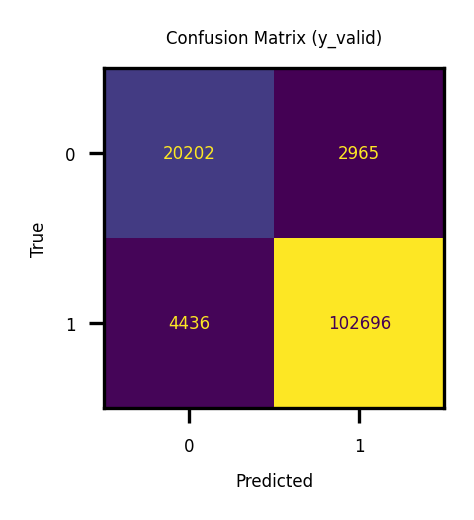

In [22]:
%%time

def RunModelv4():
    X = pd.read_feather(final_ds)
    #X = X.head(500)      # uncomment for testing
    y = X.pop('MIS_Status')
    
    model4 = process_model(X, y)
    model4.split_data(0.7)
    model4.osample(os_data = [1,0,0])
    
    model4.X, model4.y = None, None
    del X, y
    gc.collect()
    sleep(3)
    
    model4_results = model4.prep_run_model("Metrics : After Optuna Tuning",
                                           hyperparams = best_trial)
    
    text_boosted = \
        f"Total boosted rounds: {model4_results['xg_model'].get_booster().num_boosted_rounds()}"
    print(text_boosted)
    
    # save to files for reuse later
    model4_results['xg_model'].save_model(f'{workdir}modelv4.json')
    joblib.dump(model4_results, f"{workdir}model4_results.dict")   

#with warnings.catch_warnings():
#    warnings.filterwarnings('ignore')
#    warnings.simplefilter("ignore")
RunModelv4()

<i><a style="color:DarkSlateGrey" href="#toc">Back to Table Of Contents</a></i>

<a id="optuna_comparison"></a>
<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 20px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2 style='color:GhostWhite;'>1.5 Optuna Tuning Comparison</h2>
</div>

<div class="alert alert-block alert-info">
    <b>Compare metrics before and after Optuna tuning.</b><br><br>
    Comparison is made between modelv3 results in <a style="color:DarkSlateGrey" href="https://www.kaggle.com/code/josephramon/sba-xgboost-model">Part 1 Notebook</a> and modelv4 results here.
  </div>

In [23]:
def CompareResults():
    model3_results = joblib.load(f"{inputdir}model3_results.dict")
    model4_results = joblib.load(f"{workdir}model4_results.dict")
    
    preds         = model3_results['xg_model'].predict(model3_results['X_valid'])
    m3_clf_report = classification_report(model3_results['y_valid'],
                                                 preds.round(),output_dict=True)
    m3_0_f1_score = m3_clf_report['0']['f1-score'] * 100
    m3_1_f1_score = m3_clf_report['1']['f1-score'] * 100
    m3_accuracy   = m3_clf_report['accuracy'] * 100
    
    #get more metrics
    m3_precision = metrics.precision_score(model3_results['y_valid'], preds)
    m3_recall_sensitivity = metrics.recall_score(model3_results['y_valid'], preds, pos_label=1)
    m3_recall_specificity = metrics.recall_score(model3_results['y_valid'], preds, pos_label=0)
    
    m3_f1_score   = f1_score(model3_results['y_valid'], preds) * 100

    preds         = model4_results['xg_model'].predict(model4_results['X_valid'])
    m4_clf_report = classification_report(model4_results['y_valid'],
                                                 preds.round(),output_dict=True)

    m4_0_f1_score = m4_clf_report['0']['f1-score'] * 100
    m4_1_f1_score = m4_clf_report['1']['f1-score'] * 100
    m4_accuracy   = m4_clf_report['accuracy'] * 100
    
    #get more metrics
    m4_precision = metrics.precision_score(model4_results['y_valid'], preds)
    m4_recall_sensitivity = metrics.recall_score(model4_results['y_valid'], preds, pos_label=1)
    m4_recall_specificity = metrics.recall_score(model4_results['y_valid'], preds, pos_label=0)
    
    m4_f1_score   = f1_score(model4_results['y_valid'], preds) * 100

    data = {'Model v3 : No Optuna':[m3_0_f1_score, m3_1_f1_score,
                                    #m3_accuracy,
                                    m3_precision,
                                    m3_recall_sensitivity, m3_recall_specificity,
                                    m3_f1_score],
            'Model v4 : With Optuna':[m4_0_f1_score, m4_1_f1_score,
                                      #m4_accuracy,
                                      m4_precision,
                                      m4_recall_sensitivity, m4_recall_specificity,
                                      m4_f1_score]}
 
    # Creates pandas DataFrame.
    df = pd.DataFrame(data, index =['0 : f1_score',
                                    '1 : f1_score',
                                    #'Accuracy',
                                    'Precision',
                                    'Recall Sensitivity',
                                    'Recall Specificity',
                                    'f1_score'])
    print('{}F1_Score Improvement Using Optuna Suggested Parameters:{}'.format(
           mf.color.bdgreen, mf.color.end))

    print('{}Improved by {}{}{}'.format(
        mf.color.bold, mf.color.bdblue, round(m4_f1_score - m3_f1_score,2), mf.color.end))
    return df

CompareResults()

F1_Score Improvement Using Optuna Suggested Parameters:
Improved by 1.18


,Model v3 : No Optuna,Model v4 : With Optuna
0 : f1_score,81.534507,84.518356
1 : f1_score,95.338655,96.521972
Precision,0.982624,0.971939
Recall Sensitivity,0.925839,0.958593
Recall Specificity,0.924289,0.872016
f1_score,95.338655,96.521972


<div class="alert alert-block alert-warning">
We can get either a slightly higher or lower score if we run Optuna again.<br><br>
Observe that <b>Recall Specificity</b> is now lower after Optuna.  This is due to the higher <b>max_depth</b> after Optuna, which was 6 before Optuna.<br><br>
max_depth is the Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.  However, with the use of <b>Early Stopping</b>, overfitting is prevented.
      </div>

<div class="alert alert-block alert-info">
    <b>Run Modelv4 On Unseen Test Dataset</b>
  </div>


y_test RMSE    : 0.24260355528008176

y_test f1 score: 96.39236606029814 %

--------------------------------------------------

Classification Report


,precision,recall,f1-score,support
0,0.811788,0.870900,0.840306,23168.0
1,0.971635,0.956334,0.963924,107132.0
macro avg,0.891711,0.913617,0.902115,130300.0
weighted avg,0.943213,0.941144,0.941944,130300.0



Confusion Matrix using Unseen Test Data (y_test)

True Negative  : CHGOFF (0) was predicted 20177 times correctly (81.18 %)
False Negative : CHGOFF (0) was predicted 4678 times incorrectly (18.82 %)
True Positive  : P I F (1) was predicted 102454 times correctly (97.16 %)
False Positive : P I F (1) was predicted 2991 times incorrectly (2.84 %)


,Metrics Summary: y_test in %
rmse,0.242604
f1_score,96.392366
Precision,97.163450
Recall Sensitivity,95.633424
Recall Specificity,87.089952
G-Mean,91.261768


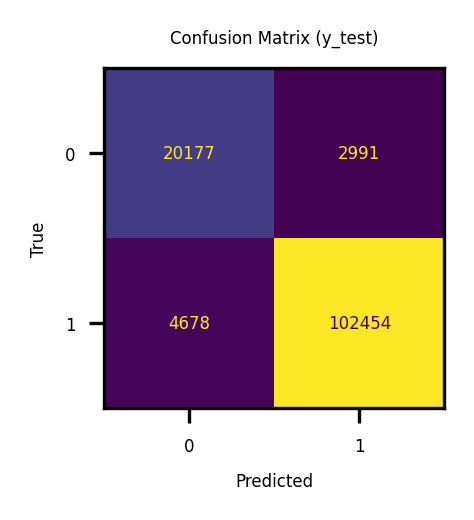

In [24]:
def Modelv4WithTestData():
    model4_results = joblib.load(f"{workdir}model4_results.dict")
    X_test = model4_results['X_test']
    y_test = model4_results['y_test']
    modelv4 = model4_results['xg_model']
    
    # Get predictions
    predictions = modelv4.predict(X_test)
    #mf.model_eval(y_test, predictions);
    mf.model_eval2( modelv4,
                    model4_results['X_train'], model4_results['y_train'],
                    X_test, y_test,
                    cmDisplay=True,
                    prtstr = 'y_test')
  
Modelv4WithTestData()

In [25]:
del best_trial, study_results
gc.collect()

4631

<div class="alert alert-block alert-info">
    <b>Observation:</b><br><br>
    <b>The Accuracy and F1 scores after Optuna tuning are improved compared to before tuning;</b> but it all depends on what hyperparameters/values are given.  A few trial sessions may be needed.<br><br>
    We have a different score in our <a style="color:DarkSlateGrey" href="https://www.kaggle.com/code/josephramon/sba-xgboost-model">Pipeline</a> as we used an Optuna hyperparameter set that was obtained from another Optuna run.
  </div>

<a id="cross_validation"></a>
<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 20px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2 style='color:GhostWhite;'>Cross Validation</h2><br>
Measure our model's quality, in RMSE.  Ideally for small datasets, but included here for reference.
</div>

In [26]:
%%time

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

def CrossVal():
    print(f'{mf.color.bold}Please wait, this will take some time{mf.color.end}')
    print()
    X = pd.read_feather(final_ds)
    #X = X.head(500)      # uncomment for testing
    y = X.pop('MIS_Status')

    cvo = process_model(X, y)   # create object from XGBoost class              
    cvo.split_data(0.7)
    cvo.osample(os_data = [1,0,0])

    cvo.X, cvo.y = None, None
    del X, y
    gc.collect()
    sleep(3)
    
    print()
    
    # get hyperparams from previous Optuna study's best trial
    study_results = joblib.load(f"{workdir}xgb_optuna_study.pkl")
    hyperparams = study_results.best_trial.params
    display(hyperparams)
    print()

    xgb_model = XGBClassifier(**hyperparams, use_label_encoder = False)

    # If we pass a pipeline instead of a model to cross_val_score, fit_params won't be 
    # recognized
    fit_params={'verbose': False,
                'eval_set': [(cvo.X_valid, cvo.y_valid)]
               }

    # Multiply by -1 since sklearn calculates *negative* RMSE
    print()
    scores = -1 * cross_val_score(xgb_model, cvo.X_train, cvo.y_train,
                                  cv=5,
                                  #scoring='neg_root_mean_squared_error',
                                  scoring = 'f1',
                                  fit_params = fit_params,
                                  verbose=15)
    sleep(5)   # allow verbosity to complete
    print()
    print(f"{mf.color.bdblue}Scores: {scores}{mf.color.end}")
    print()
    #print(f"{mf.color.bdgreen}Root Mean Squared Error (Mean): {scores.mean()}{mf.color.end}")
    print(f"{mf.color.bdgreen}F1_Score: {scores.mean()}{mf.color.end}")
    print()
    
CrossVal()

Please wait, this will take some time

MIS_Status Count ->  1 : 714212, 0 : 154451

X_train size :  608064
X_valid size :  130299
X_test size  :  130300

Please wait, resampling train data

Before Resampling train -> 1 : 499948, 0 : 108116
After Resampling  train -> 1 : 499948, 0 : 499948

Resampling Runtime : 0:00:01.432231



{'tree_method': 'gpu_hist',
 'lambda': 1.2465121277962947,
 'alpha': 0.15298716350083263,
 'gamma': 0,
 'colsample_bytree': 1.0,
 'subsample': 0.9,
 'learning_rate': 0.1,
 'n_estimators': 1000,
 'max_depth': 11,
 'random_state': 48,
 'min_child_weight': 2,
 'early_stopping_rounds': 100.0,
 'eval_metric': ['auc', 'error']}



[CV] START .....................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.973) total time=  56.8s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   56.9s remaining:    0.0s


[CV] END ................................ score: (test=0.974) total time=  57.6s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.9min remaining:    0.0s


[CV] END ................................ score: (test=0.974) total time=  58.6s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.9min remaining:    0.0s


[CV] END ................................ score: (test=0.974) total time=  59.5s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  3.9min remaining:    0.0s


[CV] END ................................ score: (test=0.975) total time=  58.8s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.9min finished



Scores: [-0.97250148 -0.97402332 -0.97443317 -0.97397363 -0.97493409]

F1_Score: -0.9739731371564144

CPU times: user 4min 50s, sys: 1.42 s, total: 4min 52s
Wall time: 5min 1s


In [27]:
sorted(metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_we

<i><a style="color:DarkSlateGrey" href="#toc">Back to Table Of Contents</a></i>

In [28]:
if alert_flag == 1:
    if kaggle_flag == 0:   # not Kaggle
        engine.say("Cross-Validation completed.")
        engine.runAndWait()
    else:
        display(Audio(url=audio_path, autoplay=True))

<a id="part2"></a>
<div style="font-family: Trebuchet MS;background-color:DarkRed;color:AliceBlue;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
<h1 id="part2" style='color:GhostWhite;'>Part 2. Miscellaneous</h1>
</div>

<a id="early_stopping_rounds"></a>
<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2 style='color:GhostWhite;'>2.1 Early Stopping Rounds</h2>
</div>

<div class="alert alert-block alert-info">
    Below is a reference on using plots to get an insight on the value to use for XGBoost's early_ stopping_rounds during fitting.</div>

MIS_Status Count ->  1 : 714212, 0 : 154451

X_train size :  608064
X_valid size :  130299
X_test size  :  130300

Please wait, resampling train data

Before Resampling train -> 1 : 499948, 0 : 108116
After Resampling  train -> 1 : 499948, 0 : 499948

Resampling Runtime : 0:00:01.115854

Please wait, Fitting model can take time ...

Hyperparameters:


{'tree_method': 'gpu_hist',
 'lambda': 1.2465121277962947,
 'alpha': 0.15298716350083263,
 'gamma': 0,
 'colsample_bytree': 1.0,
 'subsample': 0.9,
 'learning_rate': 0.1,
 'n_estimators': 1000,
 'max_depth': 11,
 'random_state': 48,
 'min_child_weight': 2,
 'eval_metric': ['error', 'logloss']}


Fitting model completed.

Preparing Predictions

Metrics:

y_valid RMSE    : 0.23834387676255514

y_valid f1 score: 96.52142038084854 %

--------------------------------------------------

Classification Report


,precision,recall,f1-score,support
0,0.819868,0.872103,0.845179,23167.0
1,0.971956,0.958565,0.965214,107132.0
macro avg,0.895912,0.915334,0.905197,130299.0
weighted avg,0.944915,0.943192,0.943872,130299.0



Confusion Matrix using Validation Data (y_valid)

True Negative  : CHGOFF (0) was predicted 20204 times correctly (81.99 %)
False Negative : CHGOFF (0) was predicted 4439 times incorrectly (18.01 %)
True Positive  : P I F (1) was predicted 102693 times correctly (97.2 %)
False Positive : P I F (1) was predicted 2963 times incorrectly (2.8 %)


,Metrics Summary: y_valid in %
rmse,0.238344
f1_score,96.521420
Precision,97.195616
Recall Sensitivity,95.856513
Recall Specificity,87.210256
G-Mean,91.431237


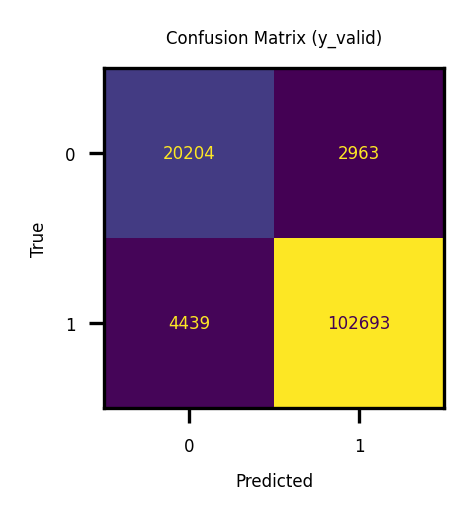

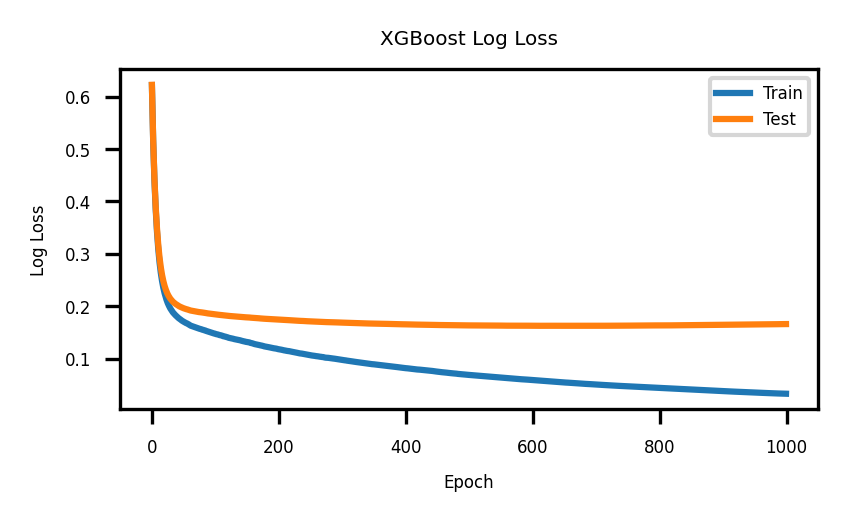

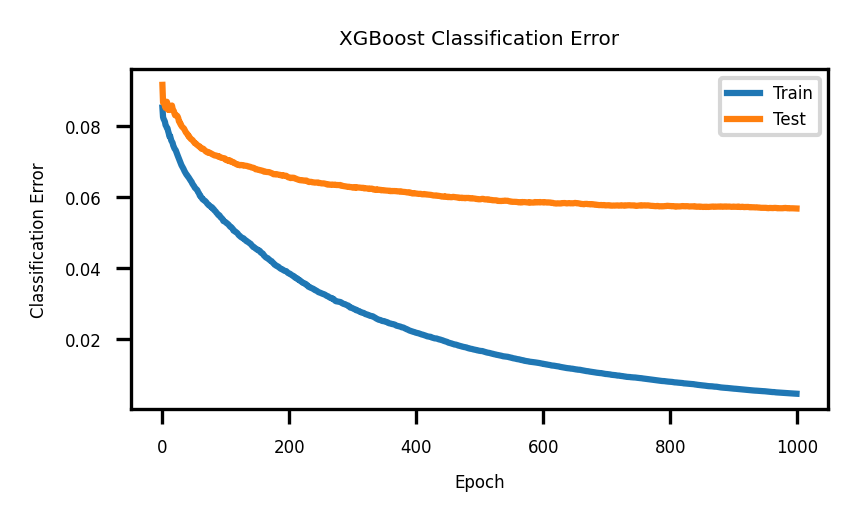

CPU times: user 2min 35s, sys: 732 ms, total: 2min 36s
Wall time: 2min 40s


In [29]:
%%time

from matplotlib import pyplot

def PlotEarlyStoppingRounds():
    X = pd.read_feather(final_ds)
    #X = X.head(500)      # uncomment for testing
    y = X.pop('MIS_Status')
    
    esr = process_model(X, y)   
    esr.split_data(0.7)
    esr.osample(os_data = [1,0,0])
    
    esr.X, esr.y = None, None
    del X, y
    gc.collect()
    sleep(3)   
    
    print()
    print(f"{mf.color.bold}Please wait, Fitting model can take time ...{mf.color.end}")
    print()
    
    # get hyperparams from previous Optuna study's best trial
    # early_stopping_rounds not included as we are trying to confirm if our value was valid
    study_results = joblib.load(f"{workdir}xgb_optuna_study.pkl")
    hyperparams = study_results.best_trial.params
    hyperparams.pop('early_stopping_rounds')
    hyperparams['eval_metric'] = ['error','logloss']
    print(f'{mf.color.bold}Hyperparameters:{mf.color.end}')
    display(hyperparams)
    print()

    xg_model = XGBClassifier(**hyperparams,use_label_encoder =False)
       
    eval_setparam = [(esr.X_train, esr.y_train),
                     (esr.X_valid, esr.y_valid)]
       
    # fit the model
    xg_model.fit(esr.X_train, esr.y_train, 
                eval_set = eval_setparam,
                verbose=False)
 
    print("Fitting model completed.")
    print()
    print('Preparing Predictions')
    
    # Get predictions
    predictions = xg_model.predict(esr.X_valid)
    
    print()
    print(f'{mf.color.underline}Metrics:{mf.color.end}')

    #eval_results = mf.model_eval(esr.y_valid, predictions)
    eval_results = mf.model_eval2(xg_model,
                                  esr.X_train, esr.y_train,
                                  esr.X_valid, esr.y_valid,
                                  cmDisplay=True)

    # retrieve performance metrics
    results = xg_model.evals_result()
    epochs = len(results['validation_0']['error'])
    x_axis = range(0, epochs)

    # what we will be looking for are the bottom areas of the plots
    
    # plot log loss
    plt.rcParams.update({'font.size': 4})
    fig, ax = pyplot.subplots(dpi=300,figsize=(3,1.5))
    # Set tick font size
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(4)
    ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
    ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
    ax.legend()
    pyplot.xlabel('Epoch')
    pyplot.ylabel('Log Loss')
    pyplot.title('XGBoost Log Loss')
    pyplot.show()

    # plot classification error
    fig, ax = pyplot.subplots(dpi=300,figsize=(3,1.5))
    ax.plot(x_axis, results['validation_0']['error'], label='Train')
    ax.plot(x_axis, results['validation_1']['error'], label='Test')
    ax.legend()
    pyplot.xlabel('Epoch')
    pyplot.ylabel('Classification Error')
    pyplot.title('XGBoost Classification Error')
    pyplot.show()
    
PlotEarlyStoppingRounds()

<i><a style="color:DarkSlateGrey" href="#toc">Back to Table Of Contents</a></i>

<div class="alert alert-block alert-info">
    From both plots, we can see that the commonly used 10% of n_estimator is a good candidate as the early_stopping_rounds parameter.  
<br><br>
    <b>Test Early Stopping Rounds</b>
    <br>
    Now we test the early_stopping_rounds parameter.  We will test it on imbalanced data, which is our data that is <b>not oversampled</b>, which is skewed heavily toward MIS_Status = 'P I F' as opposed to MIS_Status = 'CHGOFF'.  Furthermore, we use an <b>eval_metric = 'auc'</b>, which is ideal for imbalanced data.
</div>

MIS_Status Count ->  1 : 714212, 0 : 154451
Fit() Iterations:
[0]	validation_0-auc:0.96567
[1]	validation_0-auc:0.96639
[2]	validation_0-auc:0.96732
[3]	validation_0-auc:0.96794
[4]	validation_0-auc:0.96816
[5]	validation_0-auc:0.96835
[6]	validation_0-auc:0.96853
[7]	validation_0-auc:0.96898
[8]	validation_0-auc:0.96909
[9]	validation_0-auc:0.96920
[10]	validation_0-auc:0.96936
[11]	validation_0-auc:0.96960
[12]	validation_0-auc:0.96984
[13]	validation_0-auc:0.97017
[14]	validation_0-auc:0.97035
[15]	validation_0-auc:0.97066
[16]	validation_0-auc:0.97081
[17]	validation_0-auc:0.97104
[18]	validation_0-auc:0.97121
[19]	validation_0-auc:0.97132
[20]	validation_0-auc:0.97145
[21]	validation_0-auc:0.97155
[22]	validation_0-auc:0.97173
[23]	validation_0-auc:0.97190
[24]	validation_0-auc:0.97199
[25]	validation_0-auc:0.97214
[26]	validation_0-auc:0.97238
[27]	validation_0-auc:0.97250
[28]	validation_0-auc:0.97259
[29]	validation_0-auc:0.97268
[30]	validation_0-auc:0.97277
[31]	validation_0-

,precision,recall,f1-score,support
0,0.860189,0.821945,0.840632,23167.0
1,0.961863,0.971110,0.966464,107132.0
macro avg,0.911026,0.896528,0.903548,130299.0
weighted avg,0.943785,0.944589,0.944092,130299.0



Confusion Matrix using Validation Data (y_valid)

True Negative  : CHGOFF (0) was predicted 19042 times correctly (86.02 %)
False Negative : CHGOFF (0) was predicted 3095 times incorrectly (13.98 %)
True Positive  : P I F (1) was predicted 104037 times correctly (96.19 %)
False Positive : P I F (1) was predicted 4125 times incorrectly (3.81 %)


,Metrics Summary: y_valid in %
rmse,0.235395
f1_score,96.646446
Precision,96.186276
Recall Sensitivity,97.111041
Recall Specificity,82.194501
G-Mean,89.342003


CPU times: user 31.9 s, sys: 341 ms, total: 32.2 s
Wall time: 35.3 s


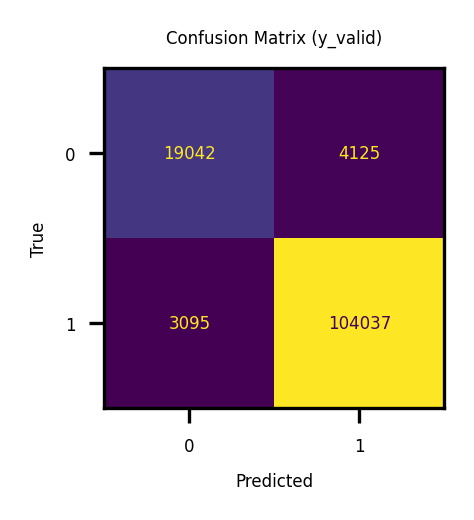

In [30]:
%%time

def RunModelv5():
    X = pd.read_feather(final_ds)
    #X = X.head(500)      # uncomment for testing
    y = X.pop('MIS_Status')

    model5 = process_model(X, y)
    model5.split_data(0.7)
    # model5.osample(os_data = [1,0,0])     # we comment out the oversampling algorithm
    
    model5.X, model5.y = None, None
    del X, y
    gc.collect()
    sleep(3)
    
    # we use the recently saved optuna study to get the hyperparams
    study = joblib.load(f"{workdir}xgb_optuna_study.pkl")
    hyperparams = study.best_trial.params
    hyperparams['eval_metric'] = 'auc'      # we change eval_metric to 'auc'
                   
    model_xg = XGBClassifier(**hyperparams, use_label_encoder =False)
 
    print(f'{mf.color.bold}Fit() Iterations:{mf.color.end}')
    eval_set = [(model5.X_valid, model5.y_valid)]
    model_xg.fit(model5.X_train, model5.y_train,
              eval_set=eval_set, verbose=True)
 
    # Get predictions
    predictions = model_xg.predict(model5.X_valid)

    print()
    #eval_results = mf.model_eval(model5.y_valid, predictions)
    eval_results = mf.model_eval2(model_xg,
                                  model5.X_train, model5.y_train,
                                  model5.X_valid, model5.y_valid,
                                  cmDisplay=True)
    
RunModelv5()

<div class="alert alert-block alert-info">
    <b>Result:</b><br>
    As we can see from above, from the verbose results of the fit() method, <b>the training stopped at a certain iteration before it reached 1000</b>, since <b>the auc score was starting to decrease</b>.  In conclusion, the early_stopping_rounds parameter works.  Although it was set at 100, at 100th iteration, the <b>auc score was still increasing</b>, so it didn't stop yet.
    <br><br>
    If we oversampled the data, the fit() method will complete the entire n_estimators = 1000, as the score is still getting better even at 1000.  In conclusion, oversampling helped get better results without reaching the overfitting threshold yet at the selected n_estimator value.  It's not just blind oversampling of course, it was a technique to solve the imbalance of data.
</div>

<i><a style="color:DarkSlateGrey" href="#toc">Back to Table Of Contents</a></i>

<a id="random_forest_classifier"></a>
<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2 style='color:GhostWhite;'>2.2 Random Forest Classifier</h2>
</div>

<div class="alert alert-block alert-info">
    This is just a reference on using a Random Forest Classifier.<br>
    <b>cuml.ensemble RandomForestClassifier</b> is used if GPU is active; otherwise, Scikit-Learn's RandomForestClassifier.
  </div>


X_train size :  608064
X_valid size :  130299
X_test size  :  130300

Please wait, resampling train data

Before Resampling train -> 1 : 499948, 0 : 108116
After Resampling  train -> 1 : 499948, 0 : 499948

Resampling Runtime : 0:00:01.125365

Please wait, Fitting model can take time ...
Fitting model completed.

Preparing Predictions
Metrics : Random Forest Classifier

cuml Score : 88.31 %


y_valid RMSE    : 0.3419742795551544

y_valid f1 score: 92.5319297007479 %

--------------------------------------------------

Classification Report


,precision,recall,f1-score,support
0,0.618737,0.891743,0.730568,23167.0
1,0.974120,0.881175,0.925319,107132.0
macro avg,0.796429,0.886459,0.827944,130299.0
weighted avg,0.910934,0.883054,0.890693,130299.0



Confusion Matrix using Validation Data (y_valid)

True Negative  : CHGOFF (0) was predicted 20659 times correctly (61.87 %)
False Negative : CHGOFF (0) was predicted 12730 times incorrectly (38.13 %)
True Positive  : P I F (1) was predicted 94402 times correctly (97.41 %)
False Positive : P I F (1) was predicted 2508 times incorrectly (2.59 %)


,Metrics Summary: y_valid in %
rmse,0.341974
f1_score,92.531930
Precision,97.412032
Recall Sensitivity,88.117463
Recall Specificity,89.174256
G-Mean,88.644285



CPU times: user 2min 19s, sys: 1.64 s, total: 2min 20s
Wall time: 2min 26s


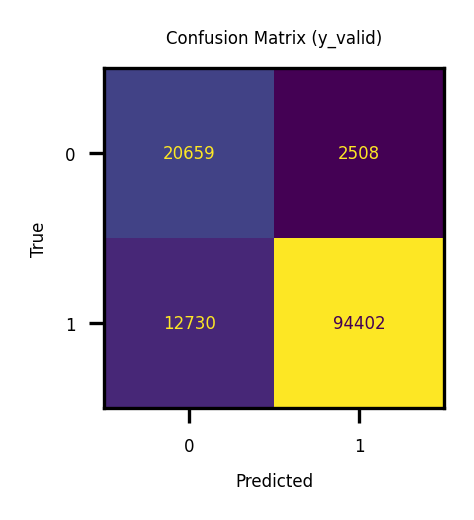

In [31]:
%%time

# run before tuning
def RunModelrf():
    X = pd.read_feather(final_ds)
    #X = X.head(500)      # uncomment for testing
    y = X.pop('MIS_Status')

    modelrf = other_models(X, y)
    modelrf.split_data(0.7)
    modelrf.osample(os_data = [1,0,0])
    
    modelrf.X, modelrf.y = None, None
    del X, y
    gc.collect()
    sleep(3)
    
    modelrf.prep_run_model("Metrics : Random Forest Classifier", modelname='rfc')

RunModelrf()

<i><a style="color:DarkSlateGrey" href="#toc">Back to Table Of Contents</a></i>

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Optuna Tuning for Random Forest</b>
</div>

<div class="alert alert-block alert-info">  
    This is just a simple sample implementation, for reference.</div>

In [32]:
%%time

def RandomForestOptunaTuning():
    X = pd.read_feather(final_ds)
    #X = X.head(500)      # uncomment for testing
    y = X.pop('MIS_Status')

    rfo = optuna_tuning(X, y)
    rfo.osample_Xy()
    rfo.split_data(0.7)
    
    rfo.X, rfo.y = None, None
    del X, y
    gc.collect()
    sleep(3)
    
    print(f'{mf.color.bold}Please wait, this will take time{mf.color.end}')
    
    nn_trials = 3
    
    if os.path.exists(f'{workdir}rfc_optuna_study_log.txt'):
        os.remove(f'{workdir}rfc_optuna_study_log.txt') 
    
    # STUDY
    
    # Turn off optuna log notes, to use own logging notes
    optuna.logging.set_verbosity(optuna.logging.WARN)
    
    # Turn on optuna log notes
    #optuna.logging.set_verbosity(optuna.logging.INFO)

    print(f"\n{mf.color.bold}Finding best trial ...{mf.color.end}")
            
    gt = dt.datetime.now()
    
    study = optuna.create_study(direction="maximize")
    
    try:
        # callbacks [self.save_study] is to save study in case memory fails
        study.optimize(lambda trial: rfo.objective_rf(trial, gt), 
                        n_trials = nn_trials,
                        callbacks = [rfo.logging_callback, rfo.save_study],
                        gc_after_trial = True,
                        catch = (RuntimeWarning,ArithmeticError,))
    except MemoryError as e:
        print(f'{mf.color.bdblue}{e} : Memory was getting low, Trial ended early{mf.color.end}')
  
    complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
    pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
    print()
    print(f'Number of finished trials: {len(study.trials)}')
    print(f'Number of pruned trials: {len(pruned_trials)}')
    print(f'Number of completed trials: {mf.color.bdgreen}{len(complete_trials)}{mf.color.end}')
    print(f'{mf.color.bdblue}Best trial: {study.best_trial.params}{mf.color.end}')
    
    joblib.dump(study, f"{workdir}rfc_optuna_study.pkl")   # save study
    # jl = joblib.load(f"{workdir}rfc_optuna_study.pkl")   # load study

    print()
    return study

study_results = RandomForestOptunaTuning()

Trial 2 done with best value: 0.9027473437610923 and parameters: {'max_features': 0.34151091953863477, 'min_samples_split': 11, 'min_samples_leaf': 10, 'max_samples': 0.8472676351381833, 'max_depth': 13, 'n_estimators': 100}. 

Number of finished trials: 3
Number of pruned trials: 0
Number of completed trials: 3
Best trial: {'max_features': 0.34151091953863477, 'min_samples_split': 11, 'min_samples_leaf': 10, 'max_samples': 0.8472676351381833, 'max_depth': 13, 'n_estimators': 100}

CPU times: user 1min 29s, sys: 1.13 s, total: 1min 30s
Wall time: 1min 42s


In [33]:
display(study_results.best_params) # Get best parameters for the objective function.

display(study_results.best_value)  # Get best objective value.

display(study_results.best_trial)  # Get best trial's information.

{'max_features': 0.34151091953863477,
 'min_samples_split': 11,
 'min_samples_leaf': 10,
 'max_samples': 0.8472676351381833,
 'max_depth': 13,
 'n_estimators': 100}

0.9027473437610923

FrozenTrial(number=2, values=[0.9027473437610923], datetime_start=datetime.datetime(2022, 6, 6, 20, 50, 14, 475305), datetime_complete=datetime.datetime(2022, 6, 6, 20, 50, 53, 126772), params={'max_features': 0.34151091953863477, 'min_samples_split': 11, 'min_samples_leaf': 10, 'max_samples': 0.8472676351381833, 'max_depth': 13, 'n_estimators': 100}, distributions={'max_features': UniformDistribution(high=1.0, low=0.15), 'min_samples_split': IntUniformDistribution(high=14, low=2, step=1), 'min_samples_leaf': IntUniformDistribution(high=14, low=1, step=1), 'max_samples': UniformDistribution(high=0.99, low=0.6), 'max_depth': CategoricalDistribution(choices=(9, 11, 13)), 'n_estimators': CategoricalDistribution(choices=(100,))}, user_attrs={}, system_attrs={}, intermediate_values={1: 0.9027473437610923}, trial_id=2, state=TrialState.COMPLETE, value=None)

In [34]:
best_trial = study_results.best_trial.params
best_trial

{'max_features': 0.34151091953863477,
 'min_samples_split': 11,
 'min_samples_leaf': 10,
 'max_samples': 0.8472676351381833,
 'max_depth': 13,
 'n_estimators': 100}

In [35]:
# Trial results dataframe sorted from best value ascending
ViewResultsAsDf()

,number,value,datetime_start,datetime_complete,duration,params_max_depth,params_max_features,params_max_samples,params_min_samples_leaf,params_min_samples_split,params_n_estimators,state
1,1,0.881693,2022-06-06 20:49:45.664793,2022-06-06 20:50:14.259415,0 days 00:00:28.594622,9,0.256373,0.707041,13,10,100,COMPLETE
0,0,0.897804,2022-06-06 20:49:16.394142,2022-06-06 20:49:45.435840,0 days 00:00:29.041698,9,0.794479,0.639273,12,13,100,COMPLETE


In [36]:
#Visualize parameter importance
optuna.visualization.plot_param_importances(study_results)

<i><a style="color:DarkSlateGrey" href="#toc">Back to Table Of Contents</a></i>

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Random Forest Score With Optuna Hyperparameters</b>
</div>


X_train size :  608064
X_valid size :  130299
X_test size  :  130300

Please wait, resampling train data

Before Resampling train -> 1 : 499948, 0 : 108116
After Resampling  train -> 1 : 499948, 0 : 499948

Resampling Runtime : 0:00:01.174509

Please wait, Fitting model can take time ...
Fitting model completed.

Preparing Predictions
Metrics : Random Forest Classifier

cuml Score : 89.72 %


y_valid RMSE    : 0.320627536090699

y_valid f1 score: 93.47562430896171 %

--------------------------------------------------

Classification Report


,precision,recall,f1-score,support
0,0.652098,0.904217,0.757736,23167.0
1,0.977398,0.895680,0.934756,107132.0
macro avg,0.814748,0.899949,0.846246,130299.0
weighted avg,0.919560,0.897198,0.903282,130299.0



Confusion Matrix using Validation Data (y_valid)

True Negative  : CHGOFF (0) was predicted 20948 times correctly (65.21 %)
False Negative : CHGOFF (0) was predicted 11176 times incorrectly (34.79 %)
True Positive  : P I F (1) was predicted 95956 times correctly (97.74 %)
False Positive : P I F (1) was predicted 2219 times incorrectly (2.26 %)


,Metrics Summary: y_valid in %
rmse,0.320628
f1_score,93.475624
Precision,97.739750
Recall Sensitivity,89.568010
Recall Specificity,90.421721
G-Mean,89.993853



CPU times: user 2min 43s, sys: 1.02 s, total: 2min 44s
Wall time: 2min 46s


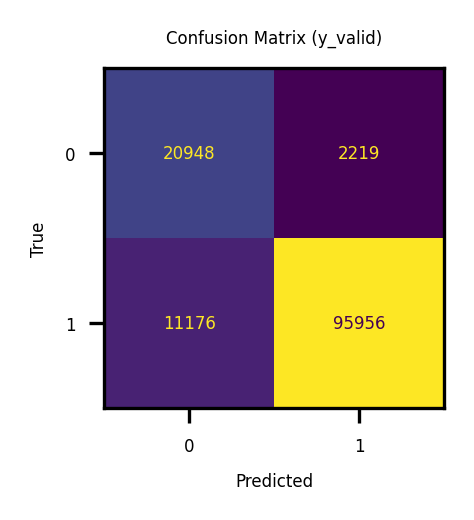

In [37]:
%%time

def RunModelrf2():
    X = pd.read_feather(final_ds)
    #X = X.head(500)      # uncomment for testing
    y = X.pop('MIS_Status')

    modelrf = other_models(X, y)
    modelrf.split_data(0.7)
    modelrf.osample(os_data = [1,0,0])
    
    modelrf.X, modelrf.y = None, None
    del X, y
    gc.collect()
    sleep(3)
    
    modelrf.prep_run_model("Metrics : Random Forest Classifier",
                            modelname='rfc', hparams = best_trial)

RunModelrf2()

<div class="alert alert-block alert-info">
    Once again, Optuna helped us get parameters that improved the score.</div>

In [38]:
del study_results, best_trial
gc.collect()

2327

<i><a style="color:DarkSlateGrey" href="#toc">Back to Table Of Contents</a></i>

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>RandomizedSearchCV</b>
</div>

<div class="alert alert-block alert-info">
    Below is a reference on using a <b>RandomizedSearchCV</b> first for Random Forest hyperparameter tuning.<br><br>
  Once done, one would have randomly narrowed down some parameters which we can base our inputs for a full <b>GridSearchCV</b> (not shown here).
    <br><br>
    Both approaches take an <b>extremely long time to run</b> using our SBA dataset, and the line to run the task is commented out.  Uncomment if you want to try.  Otherwise, <b>Optuna</b> is a much faster method.</div>

In [39]:
def ViewDefaultRFCParams():
    rf = RandomForestClassifier(random_state = 48)
    # Look at parameters used by our current forest
    print('Default parameters in use:\n')
    display(rf.get_params())

ViewDefaultRFCParams()

Default parameters in use:



{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 48,
 'verbose': 0,
 'warm_start': False}

In [40]:
from sklearn.model_selection import RandomizedSearchCV

def SuggestRFCParams():
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 500, stop = 2000, num = 3)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(6, 15, num = 4)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    display(random_grid)
    return random_grid

random_grid = SuggestRFCParams()

{'n_estimators': [500, 1250, 2000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [6, 9, 12, 15, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [41]:
%%time

def RandomSearchCV(random_grid):
    X = pd.read_feather(final_ds)
    y = X.pop('MIS_Status')

    modelrf = other_models(X, y)
    modelrf.split_data(0.7)
    modelrf.osample(os_data = [1,0,0])
    
    X_train, y_train = modelrf.X_train, modelrf.y_train
    
    del X, y, modelrf
    gc.collect()
    sleep(3)
    
    # Use the random grid to search for best hyperparameters
    # First create the base model to tune
    rf = RandomForestClassifier()

    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                                   n_iter = 5, cv = 3, verbose=10, random_state=48)

    # Fit the random search model
    rf_random.fit(X_train, y_train)
    
    return rf_random.best_params_

#rf_best_params = RandomSearchCV(random_grid)
#rf_best_params

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs


In [42]:
del random_grid #,rf_best_params 
gc.collect()

42

<i><a style="color:DarkSlateGrey" href="#toc">Back to Table Of Contents</a></i>

In the next notebook, we will run <b>Keras Binary Classification models, with Optuna and Keras Tuner.</b><br><br>
<a style="color:DarkSlateGrey;font-size:18px" href="https://www.kaggle.com/code/josephramon/sba-keras-binary-classification-and-optuna">SBA Binary Classification, Optuna, and Keras Tuner - <i style='font-size:13px'>this will open a new browser tab</i></a>